<a href="https://colab.research.google.com/github/michaelchyan/MSDS422/blob/main/Module_8_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 8: Dogs vs Cats

### Management/Research Question
### In layman’s terms, what is the management/research question of interest, and why would anyone care?
The ability for a computer to be able to distinguish between different animals signals the ability to distinguish between all kinds of things. For companies that work with photos (social media, phot hardware/software, etc.) it could easily allow for tagging different components in customers' photos.

## Ingest

In [36]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/Data Set/dogs-vs-cats-redux-kernels-edition.zip'
!unzip 'test.zip'
!unzip 'train.zip'

!mkdir train/{dog,cat}
!find train -maxdepth 1 -type f | grep 'dog' | xargs -I{} mv {} train/dog
!find train -maxdepth 1 -type f | grep 'cat' | xargs -I{} mv {} train/cat

!mkdir test/images
!find test -maxdepth 1 -type f | xargs -I{} mv {} test/images

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [86]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [87]:
train_dir = './train'
test_dir = './test'
total_train = len(os.listdir('./train/dog')) + len(os.listdir('./train/cat'))
total_test = len(os.listdir('./test/images/'))
validation_split = 0.2

batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

## EDA

## Modeling

In [88]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           validation_split=validation_split)
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           subset='training')
val_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [89]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [90]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

In [ ]:
early_stop_overfitting = True; # Stop the training if the model doesn't improve in order to prevent overfitting
learning_rate_smoothing = True; # Reduces the learning rate of the backpropagation during the fitting if the model isn't improving
learning_rate_reduction_factor = 0.5

In [95]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

if early_stop_overfitting:
    early_stop = EarlyStopping(patience=5)
    
    if not learning_rate_smoothing:
        callbacks = [early_stop]

# Reduces the learning rate of the back propagation gradient descend in the case of validation score not improving
if learning_rate_smoothing:
    learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)
    
    if not early_stop_overfitting:
        callbacks = [learning_rate_reduction]
    else:
        callbacks = [early_stop, learning_rate_reduction]

In [97]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    steps_per_epoch=(total_train * (1 - validation_split) // batch_size),
    validation_steps=(total_train * validation_split // batch_size),
    callbacks=callbacks
)

Epoch 1/10
156/156 [==============================] - 1603s 10s/step - loss: 0.6102 - accuracy: 0.6559 - val_loss: 0.5795 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 2/10
156/156 [==============================] - 1637s 10s/step - loss: 0.5562 - accuracy: 0.7112 - val_loss: 0.5139 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 3/10
156/156 [==============================] - 1640s 11s/step - loss: 0.4892 - accuracy: 0.7605 - val_loss: 0.4707 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 4/10
156/156 [==============================] - 1630s 10s/step - loss: 0.4177 - accuracy: 0.8085 - val_loss: 0.3998 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 5/10
156/156 [==============================] - 1632s 10s/step - loss: 0.3663 - accuracy: 0.8389 - val_loss: 0.3645 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 6/10
156/156 [==============================] - 1629s 10s/step - loss: 0.3143 - accuracy: 0.8639 - val_loss: 0.3208 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 7/10
156/156 [==============================] 

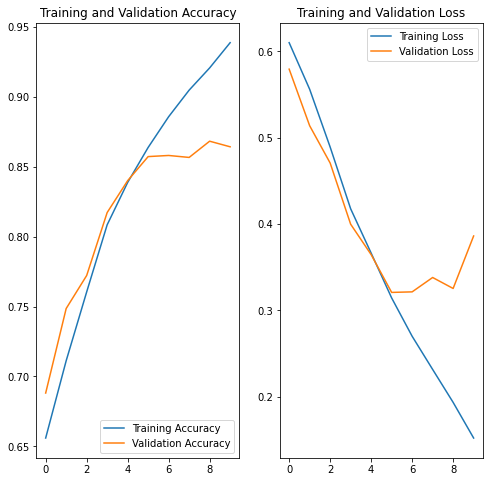

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='./test/',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=False,
                                                           class_mode=None,
                                                           batch_size=1)

Found 12500 images belonging to 1 classes.


In [100]:
test_data_gen.reset()
predictions = model.predict(test_data_gen,
                            steps=total_test,
                            verbose=1)

12500/12500 [==============================] - 369s 30ms/step


In [ ]:
train_data_gen.class_indices

In [ ]:
test_path = pathlib.Path('./test/images')
paths = [str(f) for f in test_path.glob('*')]
for path, pred in list(zip(paths, np.round(predictions)))[:10]:
  plt.imshow(Image.open(path))
  plt.show()
  print(pred)

In [ ]:
def extract_test_id(path):
   file = path.split('/')[1]
   return file.split('.')[0]

test_ids = [extract_test_id(f) for f in test_data_gen.filenames]

In [104]:
zipped = zip(test_ids, np.round(predictions.flatten()))
records = sorted(list(zipped), key=lambda kv: int(kv[0]))

In [105]:
output = pd.DataFrame.from_records(records, columns=['id', 'label'])
output.to_csv('submission.csv', index=False)

In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

# print("Classification Report:")

# print(classification_report(y_test, pred))

# print("Confusion Report:")

# print(confusion_matrix(y_test, pred))

## Conclusion
